In [1]:
from langchain_community.tools import tool
from langchain_groq import ChatGroq
from langchain.chains.llm_math.base import LLMMathChain
from langchain.agents import Tool
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
llm = ChatGroq(model = "llama-3.3-70b-versatile", temperature = 0.5)
llm.invoke("Hi, how are you?").content


"I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How can I assist you today?"

In [2]:
problem_chain = LLMMathChain.from_llm(llm=llm)
math_tool = Tool.from_function(name="Calculator",
                func=problem_chain.run,
                 description="Useful for when you need to answer questions about math. This tool is only for math questions and nothing else. Only input math expressions.")

In [3]:
math_tool.invoke("45 + 3 * 9")

'Answer: 72'

In [4]:
from langchain_tavily import TavilySearch

search = TavilySearch()



In [5]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    # Only pass the last user message
    latest_user_msg = [m for m in state["messages"] if m.type == "human"][-1]
    result = agent.invoke({"messages": [latest_user_msg]})
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name=name)
        ]
    }


In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal

members = ["Destination Expert", "Budget Planner", "Itinerary Builder"]
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

In [7]:
system_prompt = (
    "You are a supervisor managing a team of travel planning agents: {members}. "
    "Your role is to coordinate the workflow based on the user's travel request. "
    "Follow these rules:\n"
    "1. **Destination Expert** first identifies locations matching the user's preferences.\n"
    "2. **Budget Planner** checks if the destinations fit the user's budget.\n"
    "3. **Itinerary Builder** creates a day-wise plan if the budget is approved.\n"
    "4. If the user's request is fully resolved (e.g., itinerary is generated), respond with FINISH.\n"
    "Never skip steps or assign the wrong agent."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Choose strictly based on the workflow: {options}. "
            "Respond ONLY with the agent's name or FINISH.",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

In [8]:
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [9]:
import functools
import operator
from typing import Sequence, TypedDict
from typing import Annotated


from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [10]:
destination_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a **Destination Expert** specialized in travel recommendations. Your task:
1. Use **Tavily Search** to find destinations matching the user's criteria (e.g., budget, interests, duration).
2. Return ONLY relevant, concise results. Prioritize:
   - Family-friendly locations if travelers include children.
   - Budget constraints (e.g., "free attractions under Rs.X").
   - Must-see spots for short trips (<5 days).
3. Never hallucinate. If no results exist, say: "No destinations found matching your criteria."

**Tools**: You have Tavily Search to fetch real-time data. Use it for every query.

**Example Output**:
Destinations for a 3-day Bali trip under $1000:

Uluwatu Temple (free entry, scenic views)

Ubud Monkey Forest (Rs.5, cultural experience)

Nusa Penida snorkeling (Rs.50, best for adventure)
"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [11]:
budget_planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a **Budget Planner** specialized in travel cost analysis for Pakistan. Your task:
1. Use **Tavily Search** to find current prices (in PKR) for:
   - Attractions, hotels, transport in Islamabad.
   - Average meal costs (e.g., "average restaurant meal price in Islamabad").
2. Use the **Calculator** to:
   - Convert total budget to daily allowance (e.g., "Rs5000 for 3 days → Rs1666/day").
   - Compare costs against the budget.
3. **Output Format (Strictly in PKR)**:
Budget Analysis (PKR):

Total Budget: RsX

Daily Budget: RsY/day

Cost Breakdown:

Verdict: "Feasible within budget" or "Exceeds budget by RsK. Suggest: [adjustment]"
4. Rules:
   - Always show prices in Pakistani Rupees (Rs).
   - Cite Tavily for price data (e.g., "source: Tavily").
   - If no data found: "Price data unavailable for [item]. Recommend manual check."
   - Example query for Tavily: "current entry fee for Faisal Mosque in PKR 2024".
"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [12]:
itinerary_builder_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an **Itinerary Builder** that creates optimized travel schedules. Rules:
1. Input: Approved destinations + budget from Budget Planner.
2. Generate a **hour-by-hour** plan for each day, including:
   - Travel time between locations (e.g., "30min taxi").
   - Cost reminders (e.g., "Budget left: $X").
   - Diversity (mix of cultural, leisure, adventure).
3. Output format:
Day 1: [Theme]

9:00 AM: Activity 1 (Rs.X, duration)

12:00 PM: Lunch at [Place] (Rs.Y)

2:00 PM: Activity 2 (Rs.Z, duration)
...
Day 2: [Theme]
...
4. If no destinations are provided, say: "No itinerary generated. Check with Destination Expert."
"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [13]:
destination_expert_agent = create_react_agent(llm, tools=[search], prompt=destination_expert_prompt)
budget_planner_agent = create_react_agent(
    llm,
    tools=[math_tool, search],
    prompt=budget_planner_prompt
)
itinerary_builder_agent = create_react_agent(
    llm,
    tools=[],  # No tools for now
    prompt=itinerary_builder_prompt
)

In [14]:
destination_expert_node = functools.partial(agent_node, agent=destination_expert_agent, name="Destination Expert")

In [15]:
budget_planner_node = functools.partial(agent_node, agent=budget_planner_agent, name="Budget Planner")

In [16]:
itinerary_builder_node = functools.partial(agent_node, agent=itinerary_builder_agent, name="Itinerary Builder")

In [17]:
workflow = StateGraph(AgentState)
workflow.add_node("Destination Expert", destination_expert_node)
workflow.add_node("Budget Planner", budget_planner_node)
workflow.add_node("Itinerary Builder", itinerary_builder_node)
workflow.add_node("supervisor", supervisor_agent)
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

In [18]:
graph = workflow.compile()

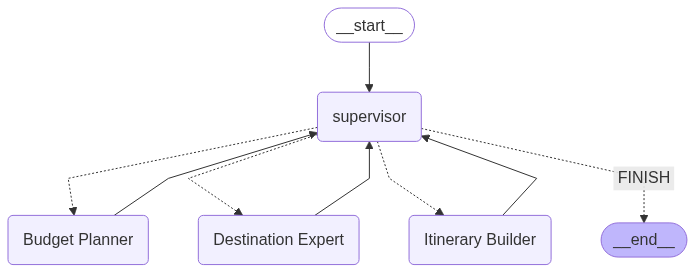

In [19]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error visualizing graph: {e}")

In [20]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="I want to visit Islamabad with a budget of Rs5000")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Destination Expert'}}
----
{'Destination Expert': {'messages': [HumanMessage(content='Based on the search results, here are some destinations in Islamabad that can be visited with a budget of Rs5000:\n\n1. Faisal Mosque: A popular tourist spot that can accommodate 300,000 worshippers and offers beautiful views.\n2. Fatima Jinnah Park: A nice park in the middle of the capital city, good for walking and spending a couple of hours.\n3. Trail No. 5: Offers beautiful views of lush green Margalla hills on one side and Islamabad plus Rawal Lake on the other.\n4. Dino Valley: A new place to explore in the Margalla Hills.\n5. Pir Sohawa City View Point: A popular place that offers a beautiful view of the city, just 17 kilometers away.\n\nThese destinations offer a mix of natural beauty, cultural experiences, and outdoor activities that can be enjoyed within the budget of Rs5000.', additional_kwargs={}, response_metadata={}, name='Destination Expert')]}}
----
{'superviso